In [1]:
import arrow
import datetime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import pandas as pd
import pickle
import xarray as xr

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

## The Grid ##

In [3]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
#mesh = nc.Dataset('../../../myResults/mesh_mask201702.nc')
gdepw = mesh.variables['gdepw_1d'][0]
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
#bathy = nc.Dataset('../../../myResults/bathymetry_201702.nc')
lats = bathy.variables['nav_lat'][:]
lons = bathy.variables['nav_lon'][:]
gdept = mesh.variables['gdept_1d'][0]
mesh.close()
bathy.close()

## Get the Data ##

In [96]:
Vic_to_PR_2015 = pd.read_csv('Vic_to_PR_2015.csv', index_col=0)
Vic_to_PR_2016 = pd.read_csv('Vic_to_PR_2016.csv', index_col=0)

Vic_to_GI_2015 = pd.read_csv('Vic_to_GI_2015.csv', index_col=0)
Vic_to_GI_2016 = pd.read_csv('Vic_to_GI_2016.csv', index_col=0)

PR_from_Vic_2015 = pd.read_csv('PR_from_Vic_2015.csv', index_col=0)
PR_from_Vic_2016 = pd.read_csv('PR_from_Vic_2016.csv', index_col=0)

GI_from_Vic_2015 = pd.read_csv('GI_from_Vic_2015.csv', index_col=0)
GI_from_Vic_2016 = pd.read_csv('GI_from_Vic_2016.csv', index_col=0)

PR_to_Vic_2015 = pd.read_csv('PR_to_Vic_2015.csv', index_col=0)
PR_to_Vic_2016 = pd.read_csv('PR_to_Vic_2016.csv', index_col=0)

GI_to_Vic_2015 = pd.read_csv('GI_to_Vic_2015.csv', index_col=0)
GI_to_Vic_2016 = pd.read_csv('GI_to_Vic_2016.csv', index_col=0)

Vic_from_PR_2015 = pd.read_csv('Vic_from_PR_2015.csv', index_col=0)
Vic_from_PR_2016 = pd.read_csv('Vic_from_PR_2016.csv', index_col=0)

Vic_from_GI_2015 = pd.read_csv('Vic_from_GI_2015.csv', index_col=0)
Vic_from_GI_2016 = pd.read_csv('Vic_from_GI_2016.csv', index_col=0)



In [133]:
def combine_GI_PR(Vic_to_PR_2015, Vic_to_GI_2015):
    Vic_to_SoG_2015 = Vic_to_PR_2015.copy()
    for key in Vic_to_PR_2015.keys():
        if key == 'transport':
            Vic_to_SoG_2015.transport = Vic_to_PR_2015.transport + Vic_to_GI_2015.transport
        else:
            Vic_to_SoG_2015[key] = ((Vic_to_PR_2015[key] * Vic_to_PR_2015.transport 
                                + Vic_to_GI_2015[key] * Vic_to_GI_2015.transport) /
                            (Vic_to_PR_2015.transport + Vic_to_GI_2015.transport))
    return Vic_to_SoG_2015

In [227]:
Vic_to_SoG_2015 = combine_GI_PR(Vic_to_PR_2015, Vic_to_GI_2015)
SoG_from_Vic_2015 = combine_GI_PR(PR_from_Vic_2015, GI_from_Vic_2015)

In [228]:
for df in [Vic_to_PR_2015, Vic_to_PR_2016,
           Vic_to_GI_2015, Vic_to_GI_2016,
           Vic_to_SoG_2015, SoG_from_Vic_2015,
           PR_from_Vic_2015, PR_from_Vic_2016,
           GI_from_Vic_2015, GI_from_Vic_2016,
           PR_to_Vic_2015, PR_to_Vic_2016,
           GI_to_Vic_2015, GI_to_Vic_2016,
           Vic_from_PR_2015, Vic_from_PR_2016,
           Vic_from_GI_2015, Vic_from_GI_2016,
          ]:
    df.index = pd.to_datetime(df.index, format="%Y-%m-%d %H:%M:%S+00:00")

In [229]:
def correct_time(Vic_to_SoG_2015, basic, factor):
    corrected_time =np.empty_like(np.array(Vic_to_SoG_2015.index))
    for i, index in enumerate(Vic_to_SoG_2015.index):
        corrected_time[i] = index + datetime.timedelta(days=basic+Vic_to_SoG_2015.final_age[i]*factor)
    Vic_to_SoG_2015['correct_time'] = corrected_time
    return (Vic_to_SoG_2015)

In [237]:
def merge(df, df2):
    nidx = df.index
    ndf = df.set_index('correct_time')
    oidx = ndf.index
   
    res = ndf.reindex(oidx.union(nidx)).interpolate('index').reindex(nidx)
    nidx = df2.index
    ndf2 = df2.set_index('correct_time')
    oidx = ndf2.index

    res2 = ndf2.reindex(oidx.union(nidx)).interpolate('index').reindex(nidx)
    corr = (res.transport.corr(res2.transport))
    res.transport = 0.5*(res.transport + res2.transport)
    return res, corr


In [265]:
basic, factor = -12.1, 1.1
Vic_to_SoG_2015 = correct_time(Vic_to_SoG_2015, basic=basic, factor=factor)
SoG_from_Vic_2015 = correct_time(SoG_from_Vic_2015, basic=-basic, factor=-factor)
deep_flux_2015, corr[i,j] = merge(Vic_to_SoG_2015, SoG_from_Vic_2015)

In [263]:
corr = np.zeros((20, 20))
for j, factor in enumerate(np.arange(1.1-0.2, 1.1+0.2, 0.02)):
    cb = 3 - 21/1.9*factor
    for i, basic in enumerate(cb+np.arange(-3.5, -2.5, 0.05)):
        Vic_to_SoG_2015 = correct_time(Vic_to_SoG_2015, basic=basic, factor=factor)
        SoG_from_Vic_2015 = correct_time(SoG_from_Vic_2015, basic=-basic, factor=-factor)
        deep_flux_2015, corr[i,j] = merge(Vic_to_SoG_2015, SoG_from_Vic_2015)
        if corr[i,j] > 0.85:
            print (basic, factor, corr[i, j])

-11.8868421053 1.08 0.850134819335
-11.8368421053 1.08 0.850314607665
-11.7868421053 1.08 0.850244805217
-12.2078947368 1.1 0.850080482852
-12.1578947368 1.1 0.850365924108
-12.1078947368 1.1 0.850605621359
-12.0578947368 1.1 0.850489863804
-12.4789473684 1.12 0.850138025987
-12.4289473684 1.12 0.850467070233
-12.3789473684 1.12 0.850602482805
-12.3289473684 1.12 0.850284805974
-12.85 1.14 0.850057344109
-12.8 1.14 0.850178521529


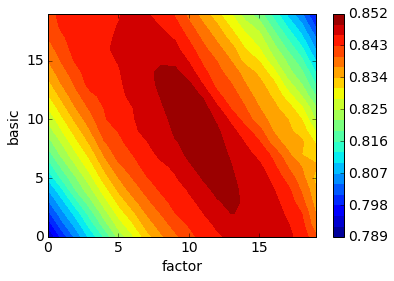

In [264]:
#plt.contourf(np.arange(0, 2, 0.1), cb+np.arange(-2, 2, 0.2), corr, 20)        
plt.contourf(corr[:, :], 20)
plt.colorbar()
plt.xlabel('factor')
plt.ylabel('basic')

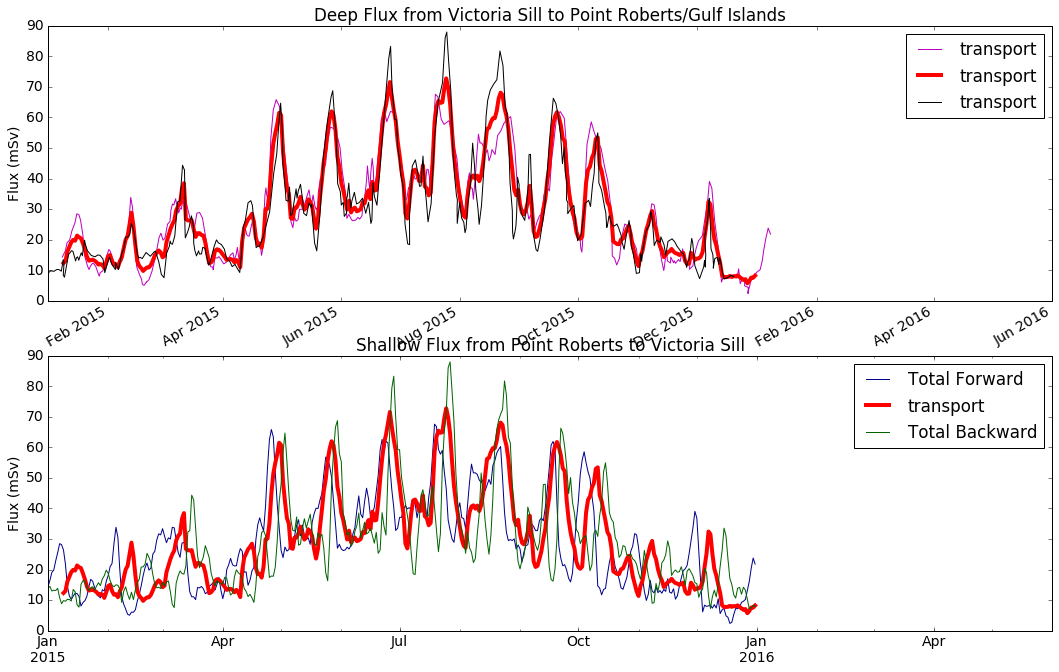

In [267]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
#(Vic_to_PR_2015.transport/1000.).plot(ax=ax[0], label="Victoria to Point Roberts", color='steelblue')
#(Vic_to_PR_2016.transport/1000.).plot(ax=ax[0], label="", color='steelblue')

#(Vic_to_GI_2015.transport/1000.).plot(ax=ax[0], label="Victoria to Gulf Islands", color='orange')
#(Vic_to_GI_2016.transport/1000.).plot(ax=ax[0], label="", color='orange')

#(PR_from_Vic_2015.transport/1000.).plot(ax=ax[0], label="Point Roberts from Victoria", color='olive')
#(PR_from_Vic_2016.transport/1000.).plot(ax=ax[0], label="", color='olive')

#(GI_from_Vic_2015.transport/1000.).plot(ax=ax[0], label="Gulf Islands from Victoria", color='darkred')
#(GI_from_Vic_2016.transport/1000.).plot(ax=ax[0], label="", color='darkred')


ax[0].plot(Vic_to_SoG_2015.correct_time, Vic_to_SoG_2015.transport/1000., color='m')
(deep_flux_2015.transport/1000.).plot(ax=ax[0], color='r', linewidth=4)
(Vic_to_SoG_2015.transport/1000.).plot(ax=ax[1], label='Total Forward', color='darkblue')

ax[0].plot(SoG_from_Vic_2015.correct_time, SoG_from_Vic_2015.transport/1000., color='k')
(deep_flux_2015.transport/1000.).plot(ax=ax[1], color='r', linewidth=4)
((PR_from_Vic_2015.transport + GI_from_Vic_2015.transport)/1000.).plot(ax=ax[1], label='Total Backward', color='darkgreen')

#(PR_to_Vic_2015.transport/1000.).plot(ax=ax[1], label="Point Roberts to Victoria", color='steelblue')
#(PR_to_Vic_2016.transport/1000.).plot(ax=ax[1], label="", color='steelblue')

#(GI_to_Vic_2015.transport/1000.).plot(ax=ax[1], label="Gulf Islands to Victoria", color='orange')
#(GI_to_Vic_2016.transport/1000.).plot(ax=ax[1], label="", color='orange')

#(Vic_from_PR_2015.transport/1000.).plot(ax=ax[1], label="Victoria from Point Roberts", color='olive')
#(Vic_from_PR_2016.transport/1000.).plot(ax=ax[1], label="", color='olive')

#(Vic_from_GI_2015.transport/1000.).plot(ax=ax[1], label="Victoria from Gulf Islands", color='darkred')
#(Vic_from_GI_2016.transport/1000.).plot(ax=ax[1], label="", color='darkred')

#((PR_to_Vic_2015.transport + GI_to_Vic_2015.transport)/1000.).plot(ax=ax[1], label='Total Forward', color='darkblue')
#((Vic_from_PR_2015.transport + Vic_from_GI_2015.transport)/1000.).plot(ax=ax[1], label='Total Backward', color='darkgreen')

ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts/Gulf Islands")
ax[1].set_title("Shallow Flux from Point Roberts to Victoria Sill")
for ax in [ax[0], ax[1]]:
    ax.set_ylabel('Flux (mSv)')
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2016, 6, 1))
    ax.legend()

In [26]:
print('from Vic')
print ('to PR', 0.5*(fullsouth_all_2015.transport.mean() + fullsouth_all_2016.transport.mean()))
print ('to GI', south_gulfislands.transport.mean())
print ('to PS/D', south_puget.transport.mean() + south_discovery.transport.mean())
print ('total', 0.5*(fullsouth_all_2015.transport.mean() + fullsouth_all_2016.transport.mean()) +
      south_gulfislands.transport.mean() + south_puget.transport.mean() + south_discovery.transport.mean())

from Vic
to PR 24939.30762099509
to GI 2494.3419571996405
to PS/D 34508.15828209351
total 61941.80786028824


In [28]:
print('from PR')
print ('to VS', 0.5*(fullnorth_all_2015.transport.mean() + fullnorth_all_2016.transport.mean()))
print ('to GI', north_gulfislands.transport.mean())
print ('to PS/D', north_puget.transport.mean() + north_discovery.transport.mean())
print ('total', 0.5*(fullnorth_all_2015.transport.mean() + fullnorth_all_2016.transport.mean())+
      north_gulfislands.transport.mean()+north_puget.transport.mean() + north_discovery.transport.mean())

from PR
to VS 20848.996024600692
to GI 6422.191094518156
to PS/D 3978.501865761992
total 31249.68898488084


In [27]:
back_south_pointroberts = pd.read_csv('back_south_pointroberts.csv')
back_south_gulfislands = pd.read_csv('back_south_gulfislands.csv')
back_south_puget = pd.read_csv('back_south_puget.csv')
back_south_discovery = pd.read_csv('back_south_discovery.csv')
print('into VS')
print ('from PR', back_south_pointroberts.transport.mean())
print ('from GI', back_south_gulfislands.transport.mean())
print ('from PS/D', back_south_puget.transport.mean() + back_south_discovery.transport.mean())
print ('total',  back_south_pointroberts.transport.mean()+
      back_south_gulfislands.transport.mean() + back_south_puget.transport.mean() + back_south_discovery.transport.mean())

into VS
from PR 21238.71507128748
from GI 7609.7508646156375
from PS/D 38501.20922983506
total 67349.67516573818


In [29]:
back_north_victoriasill = pd.read_csv('back_north_victoriasill.csv')
back_north_gulfislands = pd.read_csv('back_north_gulfislands.csv')
back_north_puget = pd.read_csv('back_north_puget.csv')
back_north_discovery = pd.read_csv('back_north_discovery.csv')
print('into PR')
print ('from VS', back_north_victoriasill.transport.mean())
print ('from GI', back_north_gulfislands.transport.mean())
print ('from PS/D', back_north_puget.transport.mean() + back_north_discovery.transport.mean())
print ('total', back_north_victoriasill.transport.mean()+back_north_gulfislands.transport.mean()+
      back_north_puget.transport.mean() + back_north_discovery.transport.mean())

into PR
from VS 25495.45177727469
from GI 3347.188255068052
from PS/D 2452.704112571053
total 31295.344144913797


## Depths ##

In [41]:
print ('to PR', 0.25*(fullsouth_all_2015.init_depth.mean() + fullsouth_all_2016.init_depth.mean())
       + 0.25*(fullsouth_all_2015.final_depth.mean() + fullsouth_all_2016.final_depth.mean()))
print ('to PR', 0.5*(fullsouth_all_2015.init_depth.mean() + fullsouth_all_2016.init_depth.mean()),
       0.5*(fullsouth_all_2015.final_depth.mean() + fullsouth_all_2016.final_depth.mean()))
print ('to VS', 0.25*(fullnorth_all_2015.init_depth.mean() + fullnorth_all_2016.init_depth.mean())
       + 0.25*(fullnorth_all_2015.final_depth.mean() + fullnorth_all_2016.final_depth.mean()))
print ('to GI', 0.5*(south_gulfislands.final_depth.mean() + south_gulfislands.init_depth.mean()))
print ('at GI', south_gulfislands.final_depth.mean())
print ('to PS/D', 0.5*(south_puget.final_depth.mean() + south_puget.init_depth.mean()))

to PR -72.97870315641413
to PR -62.87296003498079 -83.08444627784746
to VS -28.058060635002715
to GI -51.70378937724074
at GI -40.6183850599234
to PS/D -41.81546851736172


## Calculation of Tides moved to "Calculate Tides" ##
Here just read them

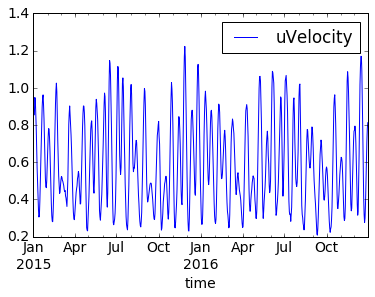

In [268]:
low_pass_tide = pd.read_csv('low_pass_tide.csv', index_col=0)
low_pass_tide.index = pd.to_datetime(low_pass_tide.index, format="%Y-%m-%d")
low_pass_tide.plot()

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


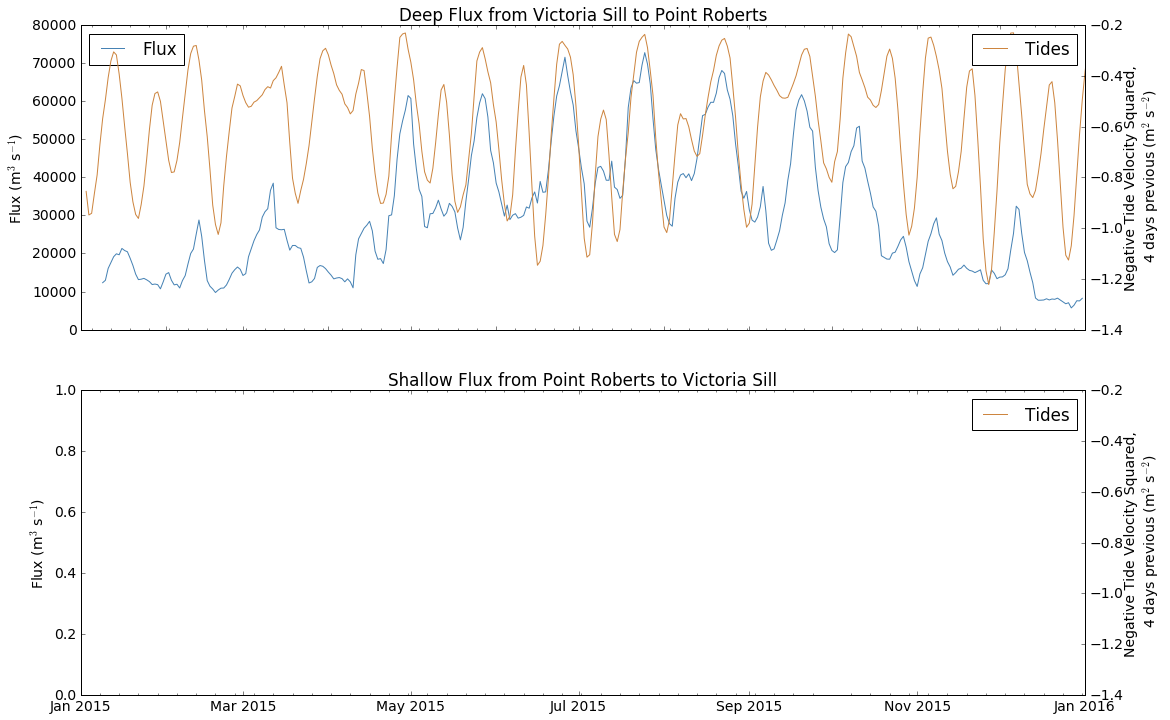

In [270]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
#fullsouth_all_2015.transport.plot(ax=ax[0], label="", legend=False, color='steelblue')
#fullnorth_all_2015.transport.plot(ax=ax[1], label="", legend=False, color='steelblue')
#fullsouth_all_2016.plot(ax=ax[0], y='transport', label="", legend=False, color='steelblue')
#fullnorth_all_2016.plot(ax=ax[1], y='transport', label="", legend=False, color='steelblue')
#fullsouth_all_2017.plot(ax=ax[0], y='transport', label="Flux", legend=False, color='steelblue')
#fullnorth_all_2017.plot(ax=ax[1], y='transport', label="Flux", legend=False, color='steelblue')
deep_flux_2015.plot(ax=ax[0], y='transport', label="Flux", legend=False, color='steelblue')
ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts")
ax[1].set_title("Shallow Flux from Point Roberts to Victoria Sill")
for ax in [ax[0], ax[1]]:
    ax2 = ax.twinx()
    ax.set_ylabel('Flux (m$^3$ s$^{-1}$)')
    (-low_pass_tide.shift(0)).plot(ax=ax2, y='uVelocity', color = 'peru', legend=False, label='Tides')
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2016, 1, 1))
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('Negative Tide Velocity Squared,\n 4 days previous (m$^2$ s$^{-2}$)')

## Summer Deep Water Variability ##

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -3
ii, jj = 190, 300
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

## Spring Deep Water Variability ##

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -3
ii, jj = 100, 190
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

## Winter Deep Water Variability : note change in lag

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -5
ii, jj = 0-lag, 100
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

# Impact of Density Difference #

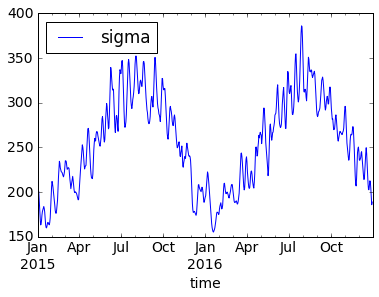

In [271]:
msouth = pd.read_csv('south_sigma.csv', index_col=0)
mnorth = pd.read_csv('north_sigma.csv', index_col=0)
msouth.index = pd.to_datetime(msouth.index, format="%Y-%m-%d")
mnorth.index = pd.to_datetime(mnorth.index, format="%Y-%m-%d")
(msouth-mnorth).plot()

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


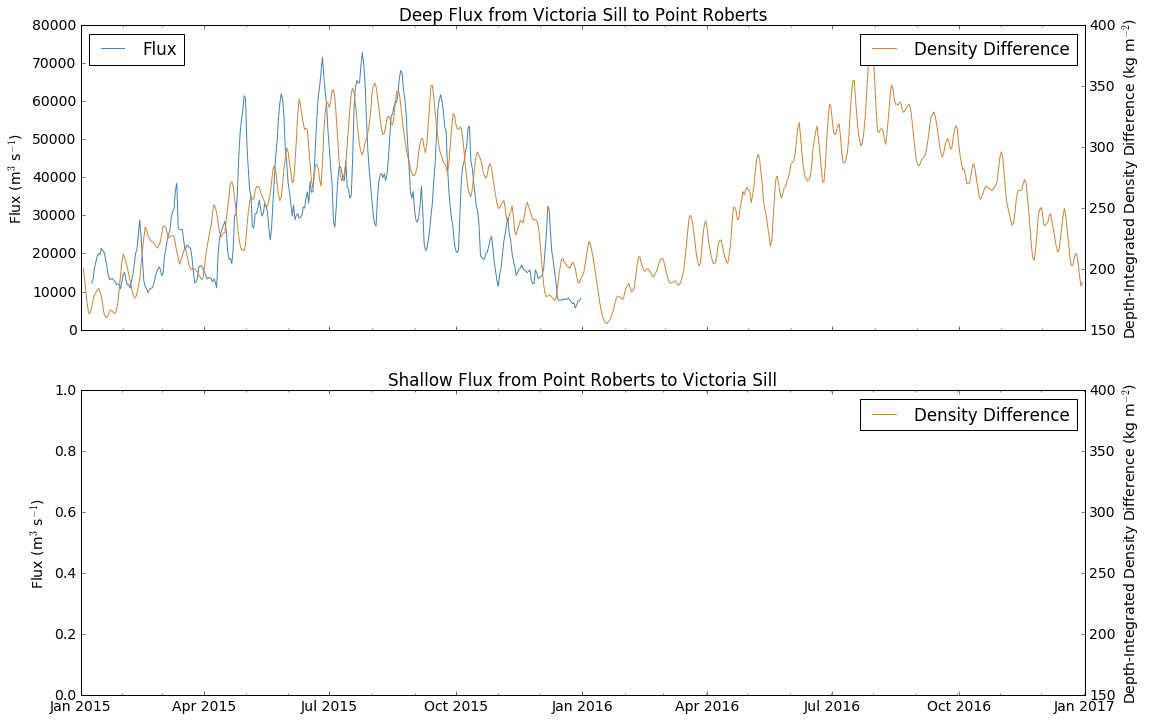

In [272]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
#fullsouth_all_2015.transport.plot(ax=ax[0], label="", legend=False, color='steelblue')
#fullnorth_all_2015.transport.plot(ax=ax[1], label="", legend=False, color='steelblue')
#fullsouth_all_2016.plot(ax=ax[0], y='transport', label="", legend=False, color='steelblue')
#fullnorth_all_2016.plot(ax=ax[1], y='transport', label="", legend=False, color='steelblue')
#flux_line_u = fullsouth_all_2017.plot(ax=ax[0], y='transport', label="Flux", legend=False, color='steelblue')
#flux_line_l = fullnorth_all_2017.plot(ax=ax[1], y='transport', label="Flux", legend=False, color='steelblue')
deep_flux_2015.plot(ax=ax[0], y='transport', label="Flux", legend=False, color='steelblue')
#low_pass_tide.plot(ax=ax2, c='r')
#ax.set_xlim(fullsouth_transport.index[0], time[-1])
ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts")
ax[1].set_title("Shallow Flux from Point Roberts to Victoria Sill")
for ax in [ax[0], ax[1]]:
    ax2 = ax.twinx()
    ax.set_ylabel('Flux (m$^3$ s$^{-1}$)')
    density_line = (msouth-mnorth).plot(ax=ax2, y='sigma', legend=False, label='Density Difference',  color = 'peru')
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2017, 1, 1))
    ax2.set_ylabel('Depth-Integrated Density Difference (kg m$^{-2}$)')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Wind #

In [13]:
wind = pd.read_csv('low_pass_wind.csv', index_col=0)
wind.index = pd.to_datetime(wind.index, format="%Y-%m-%d")

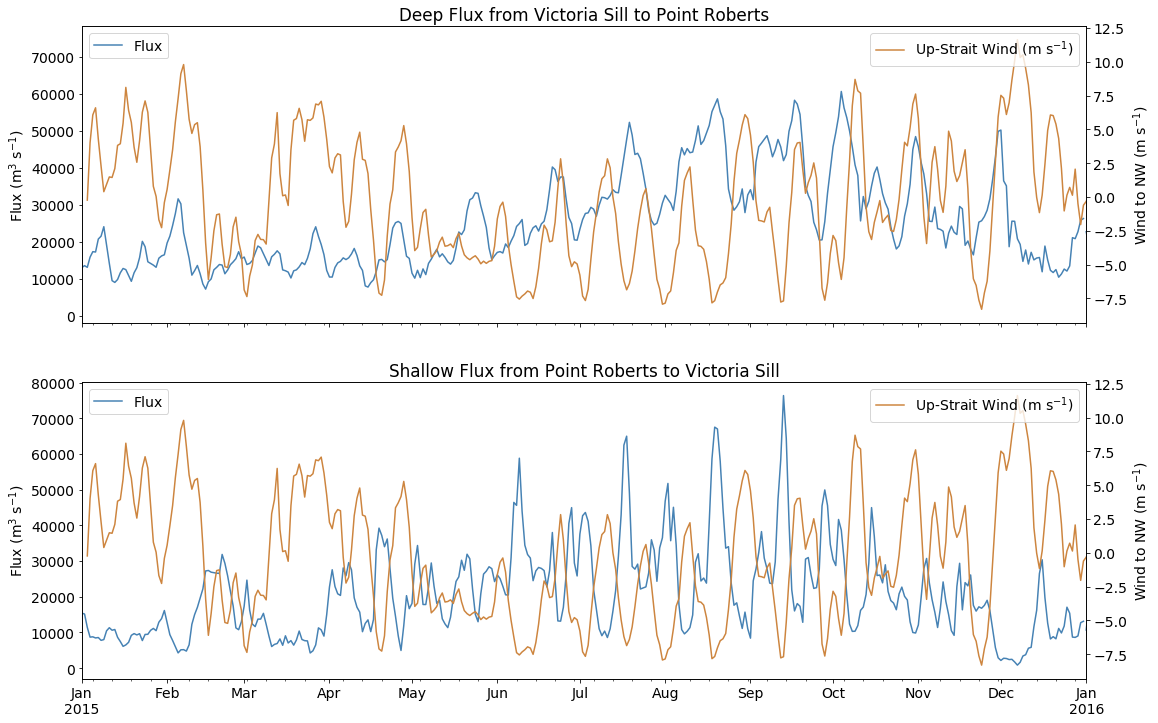

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
fullsouth_all_2015.transport.plot(ax=ax[0], label="", legend=False, color='steelblue')
fullnorth_all_2015.transport.plot(ax=ax[1], label="", legend=False, color='steelblue')
fullsouth_all_2016.plot(ax=ax[0], y='transport', label="", legend=False, color='steelblue')
fullnorth_all_2016.plot(ax=ax[1], y='transport', label="", legend=False, color='steelblue')
flux_line_u = fullsouth_all_2017.plot(ax=ax[0], y='transport', label="Flux", legend=False, color='steelblue')
flux_line_l = fullnorth_all_2017.plot(ax=ax[1], y='transport', label="Flux", legend=False, color='steelblue')
#low_pass_tide.plot(ax=ax2, c='r')
#ax.set_xlim(fullsouth_transport.index[0], time[-1])
ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts")
ax[1].set_title("Shallow Flux from Point Roberts to Victoria Sill")
for ax in [ax[0], ax[1]]:
    ax2 = ax.twinx()
    ax.set_ylabel('Flux (m$^3$ s$^{-1}$)')
    wind.plot(ax=ax2, y='wind', legend=False, label='Up-Strait Wind (m s$^{-1}$)',  color = 'peru')
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2016, 1, 1))
    ax2.set_ylabel('Wind to NW (m s$^{-1}$)')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')